# Feature Sieve for Behavioral Cloning

## Atari Game: Space Invaders(D4RL)

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gymnasium as gym
from tqdm import tqdm
import sys
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
#Setting random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

In [3]:
# creating the environment to suit the dataset
env = gym.make("SpaceInvadersNoFrameskip-v4")
env = gym.wrappers.GrayScaleObservation(env, keep_dim=False)
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.FrameStack(env, 4)

#Environment Infos
print(f"Observation Space: {env.observation_space.shape}")
print(f"Action Space: {env.action_space.n}")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Observation Space: (4, 84, 84)
Action Space: 6


In [4]:
#Loading the Dataset
OBSERVATION_DIR = "./Datasets/Observations/"
ACTIONS_DIR = "./Datasets/Actions/"

observations = np.load("./Datasets/space_invaders_obs.npy")
actions = np.load("./Datasets/space_invaders_actions.npy")
actions = actions.reshape((-1,))

print(observations.shape)
print(actions.shape)

(1000000, 4, 84, 84)
(1000000,)


In [5]:
class AtariDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = observations
        self.actions = actions

    def __getitem__(self, index):
        obs = self.observations[index]
        action = self.actions[index]
        return obs, action

    def __len__(self):
        return self.observations.shape[0]

In [6]:
#Datapoints for the dataset
TRAIN_DATAPTS = int(0.95 * observations.shape[0])
VAL_DATAPTS = int(0.025 * observations.shape[0])
TEST_DATAPTS = int(0.025 * observations.shape[0])

print(f"Training Dataset size: {TRAIN_DATAPTS}")
print(f"Test Dataset Size :{TEST_DATAPTS}")
print(f"Validation Dataset Size: {VAL_DATAPTS}")

#Spiting Observations and Actions
train_observations = observations[:TRAIN_DATAPTS]
val_observations = observations[TRAIN_DATAPTS: TRAIN_DATAPTS + VAL_DATAPTS]
test_observations = observations[TRAIN_DATAPTS + VAL_DATAPTS: ]

train_actions = actions[:TRAIN_DATAPTS]
val_actions = actions[TRAIN_DATAPTS: TRAIN_DATAPTS + VAL_DATAPTS]
test_actions = actions[TRAIN_DATAPTS + VAL_DATAPTS: ]

#Datasets
train_dataset = AtariDataset(train_observations, train_actions)
val_dataset = AtariDataset(val_observations, val_actions)
test_dataset = AtariDataset(test_observations, test_actions)

#DataLoaders
train_dataloader = DataLoader(dataset = train_dataset, shuffle = True, batch_size=128)
val_dataloader = DataLoader(dataset = val_dataset, shuffle = True, batch_size = 128)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = True, batch_size = 128)

Training Dataset size: 950000
Test Dataset Size :25000
Validation Dataset Size: 25000


In [7]:
# Early Stopping 
class Early_Stopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = float('-inf')

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_validation_acc - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# CNN Model
A Simple CNN model from the DQN paper

In [8]:
class CNN(nn.Module):
    def __init__(self, num_channels, num_actions):
        super(CNN, self).__init__()
        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(num_channels, 32, 8, stride=4)
        self.batchnorm1 = nn.BatchNorm2d(num_features = 32)
        self.dropout1 = nn.Dropout(p =0.5)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(num_features = 64)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(num_features = 64)

        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        
        x = x.reshape((x.shape[0], -1))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [9]:
# Training function
def train_cnn(model, train_dataloader, val_dataloader, epochs = 100, lr =1e-3, wd= 1e-5, verbose = True, early_stop = False, patience = 3, min_delta = 0.1):
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = wd)

    if verbose:
        print("Training Model...............")
    if early_stop:
        early_stopper = Early_Stopper(patience = patience, min_delta = min_delta)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in tqdm(range(epochs)):
        tloss = 0
        tloss_num = 0
        correct = 0
        total = 0
        
        model.train()
        for batch_idx, data in enumerate(train_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

            tloss += loss.detach().cpu()
            tloss_num += 1

            _, preds = torch.max(out.data, 1)
            correct += (preds == y).sum().item()
            total += y.shape[0]

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            vcorrect = 0
            vtotal = 0

            for batch_idx, data in enumerate(val_dataloader):
                x, y = data
                x = x.to(torch.float32).to(device)
                y = y.to(torch.long).to(device)

                out = model(x)
                loss = F.cross_entropy(out, y)

                vloss += loss.detach().cpu()
                vloss_num +=1

                _, preds = torch.max(out.data, 1)
                vcorrect += (preds == y).sum().item()
                vtotal += y.shape[0]

        train_losses.append(float(tloss / tloss_num))
        train_accs.append(float(correct/total))
        val_losses.append(float(vloss / vloss_num))
        val_accs.append(float(vcorrect / vtotal))

        if verbose:
            print(f"Epoch :{epoch}/{epochs}")
            print(f"Training Loss: {tloss / tloss_num} Accuracy: {correct / total}")
            print(f"Validation Loss: {vloss / vloss_num} Accuracy: {vcorrect / total}")

        if early_stop:
            if early_stopper.early_stop(vcorrect / total):
                break

    return model, train_losses, train_accs, val_losses, val_accs

def eval_cnn(model, test_dataloader):
    model.eval()
    tloss = 0
    tloss_num = 0
    total = 0
    correct = 0

    for batch_idx, data in enumerate(test_dataloader):
        x, y = data
        x = x.to(torch.float32).to(device)
        y = y.to(torch.long).to(device)

        out = model(x)
        loss = F.cross_entropy(out, y)

        tloss += loss.detach().cpu()
        tloss_num += 1

        _, preds = torch.max(out.data, 1)
        total += y.shape[0]
        correct += (preds == y).sum().item()

    print(f"Test Loss: {tloss / tloss_num} Accuracy:{correct / total}")
    return tloss / tloss_num, correct / total

In [10]:
def plot_loss_curves(train_loss, val_loss, test_loss, model_name, metric = "loss", epochs = 100):
    plt.plot(range(epochs), train_loss, color = "blue", label = f"Training {metric}")
    plt.plot(range(epochs), val_loss, color = "red", label = f"Validation {metric}")
    plt.plot(range(epochs), [test_loss] * epochs, color = "green", label = f"Test {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(model_name)
    plt.legend()
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:48:48<00:00, 65.29s/it]


Test Loss: 1.388924241065979 Accuracy:0.4184


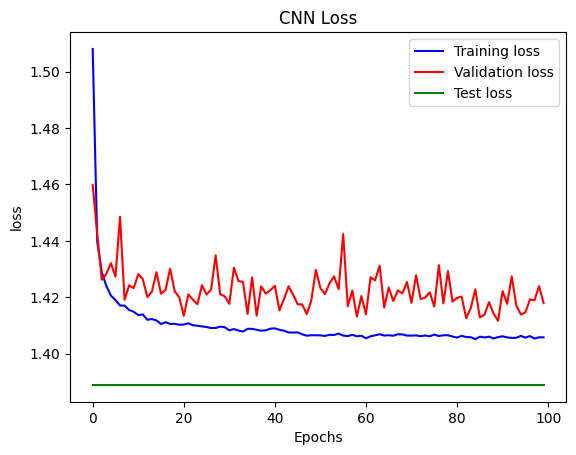

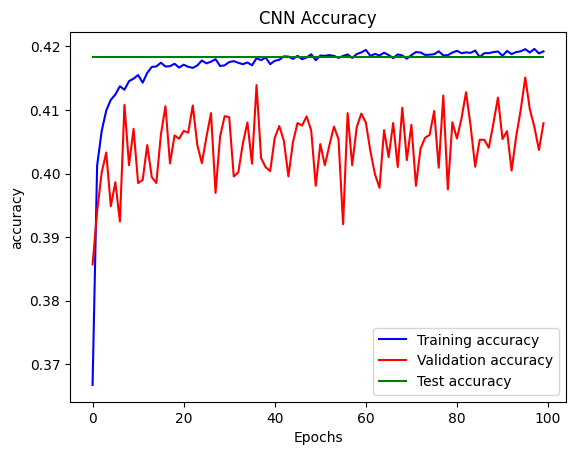

In [34]:
epochs = 100
model = CNN(4, 6).to(device)
model, train_loss, train_acc, val_loss, val_acc = train_cnn(model, train_dataloader, val_dataloader, epochs = epochs, wd=1e-3, verbose = False, early_stop = True, min_delta = 0.1)
test_loss, test_acc = eval_cnn(model, test_dataloader)

plot_loss_curves(train_loss, val_loss, test_loss, epochs = epochs, model_name = "CNN Loss", metric = "loss")
plot_loss_curves(train_acc, val_acc, test_acc, epochs = epochs, model_name = "CNN Accuracy", metric = "accuracy")

In [14]:
#Hyperparameter Tuning
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
wds = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

test_accs = np.zeros((len(lrs), len(wds)))
test_losses = np.zeros((len(lrs), len(wds)))

for i in range(len(lrs)):
    for j in range(len(wds)):
        print(f"LR: {lrs[i]} WD:{wds[j]}")
        model = CNN(4, 6).to(device)
        model, train_loss, train_acc, val_loss, val_acc = train_cnn(model, train_dataloader, val_dataloader, epochs = 10, verbose = False, lr = lrs[i], wd = wds[j])
        test_loss,  test_acc = eval_cnn(model, test_dataloader)

        test_losses[i,j] = test_loss
        test_accs[i,j] = test_acc

best_lr, best_wd = np.unravel_index(np.min(test_losses), test_losses)
best_lr_, best_wd_ = np.unravel_index(np.min(test_accs), test_accs)

print(f"Best LR: {best_lr} Best WD: {best_wd} with respect to test loss")
print(f"Best LR: {best_lr_} Best WD: {best_wd_} with respect to test accuracy")

LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:50<00:00, 65.07s/it]


Test Loss: 1.423556923866272 Accuracy:0.41088
LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:02<00:00, 66.27s/it]


Test Loss: 1.4321308135986328 Accuracy:0.40836
LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:53<00:00, 65.30s/it]


Test Loss: 1.4216750860214233 Accuracy:0.41524
LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:48<00:00, 64.82s/it]


Test Loss: 1.4088143110275269 Accuracy:0.4096
LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:45<00:00, 64.56s/it]


Test Loss: 1.4474503993988037 Accuracy:0.40044
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:44<00:00, 64.45s/it]


Test Loss: 1.9755665063858032 Accuracy:0.37596
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:40<00:00, 64.08s/it]


Test Loss: 1.9531080722808838 Accuracy:0.3686
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:50<00:00, 65.07s/it]


Test Loss: 1.5408586263656616 Accuracy:0.40716
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:07<00:00, 66.71s/it]


Test Loss: 1.3750466108322144 Accuracy:0.41928
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:58<00:00, 65.87s/it]


Test Loss: 1.515895962715149 Accuracy:0.3448
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:55<00:00, 65.56s/it]


Test Loss: 1.5715885162353516 Accuracy:0.40856
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:02<00:00, 66.29s/it]


Test Loss: 1.3961756229400635 Accuracy:0.42932
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:55<00:00, 65.53s/it]


Test Loss: 1.371903896331787 Accuracy:0.42756
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:01<00:00, 66.11s/it]


Test Loss: 1.4484745264053345 Accuracy:0.38492
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:57<00:00, 65.77s/it]


Test Loss: 1.6476225852966309 Accuracy:0.30344
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:54<00:00, 65.46s/it]


Test Loss: 1.7869991064071655 Accuracy:0.1838
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:04<00:00, 66.46s/it]


Test Loss: 1.500490665435791 Accuracy:0.34772
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:08<00:00, 66.83s/it]


Test Loss: 1.5160481929779053 Accuracy:0.36808
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:59<00:00, 65.90s/it]


Test Loss: 1.6489222049713135 Accuracy:0.30956
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:37<00:00, 63.71s/it]


Test Loss: 1.788910984992981 Accuracy:0.18224
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:25<00:00, 68.57s/it]


Test Loss: 3022.29296875 Accuracy:0.18208
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:56<00:00, 65.70s/it]


Test Loss: 113.28730773925781 Accuracy:0.17872
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:57<00:00, 65.71s/it]


Test Loss: 1.8977649211883545 Accuracy:0.15676
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:07<00:00, 66.74s/it]


Test Loss: 1.7958368062973022 Accuracy:0.15668
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:55<00:00, 65.57s/it]


Test Loss: 1.7911336421966553 Accuracy:0.18224


TypeError: only integer scalar arrays can be converted to a scalar index

In [25]:
# Finetuned model
model = CNN(4, 6).to(device)
model, train_loss, train_accs, val_loss, val_accs = train_cnn(model, train_dataloader, val_dataloader, epochs =100, verbose = False, lr = 1e-3, wd = 1e-3)
test_loss, test_acc = eval_cnn(model, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:51:47<00:00, 67.07s/it]


Test Loss: 1.4308161735534668 Accuracy:0.40348


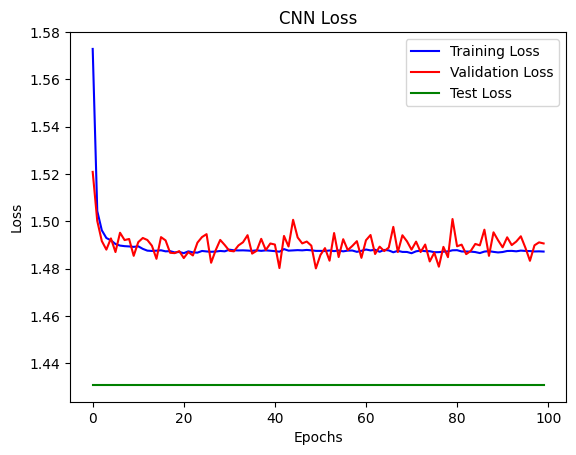

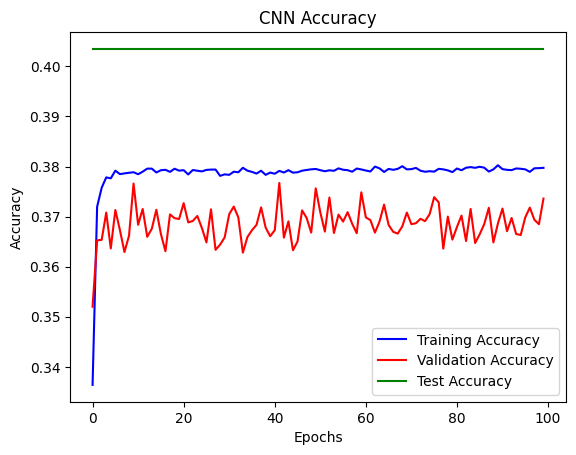

In [26]:
plot_loss_curves(train_loss, val_loss, test_loss, epochs =100, model_name = "CNN Loss", metric = "Loss")
plot_loss_curves(train_accs, val_accs, test_acc, epochs =100, model_name = "CNN Accuracy", metric = "Accuracy")

# Resnet Architecture
## Smallest ResNet variant: ResNet-18

In [11]:
# ResNet 18 model for Age Prediction
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

## Resnet Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## ResNet
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, in_channels):
        self.num_classes = num_classes
        self.inplanes = 64
        in_dim = in_channels
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = F.softmax(self.fc(x), dim = -1)
        return logits

## ResNet 34 model
def resnet18(num_classes, in_channels):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[2, 2, 2, 2],
                   num_classes=num_classes,
                   in_channels=in_channels)
    return model

In [ ]:
resnet_model = resnet18(6, 4).to(device)
resnet_model, train_loss, train_acc, val_loss, val_acc = train_cnn(resnet_model, train_dataloader, val_dataloader, epochs = 20, verbose = False)
test_loss, test_acc = eval_cnn(resnet_model, test_dataloader)

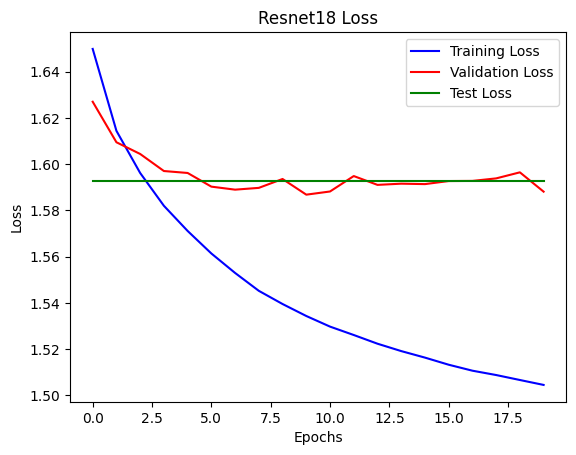

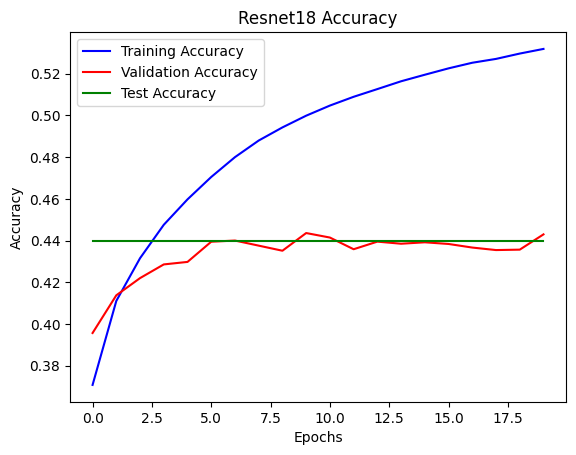

In [38]:
plot_loss_curves(train_loss, val_loss, test_loss, epochs =20, model_name = "Resnet18 Loss", metric = "Loss")
plot_loss_curves(train_acc, val_acc, test_acc, epochs =20, model_name = "Resnet18 Accuracy", metric = "Accuracy")

# Feature Sieve Model
## Architecture 1
Auxilary network is connected to the 1st convolutional layer
Main network: CNN Model

In [12]:
class Feature_Sieve(nn.Module):
    def __init__(self, num_channels, num_actions):
        super(Feature_Sieve, self).__init__()
        self.num_actions = num_actions

        #Main Network
        self.conv1 = nn.Conv2d(num_channels, 32, 8, stride=4)
        self.batchnorm1 = nn.BatchNorm2d(num_features = 32)
        self.dropout = nn.Dropout(p =0.5)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(num_features = 64)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(num_features = 64)

        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

        #Aux network
        self.aux_fc1 = nn.Linear(12800, 512)
        self.aux_fc2 = nn.Linear(512, num_actions)

        self.params = nn.ModuleDict(
            {
                "main" : nn.ModuleList([self.conv1, self.conv2, self.conv3, self.batchnorm1, self.batchnorm2, self.batchnorm3, self.fc1, self.fc2]),
                "aux" : nn.ModuleList([self.aux_fc1, self.aux_fc2]),
                "forget" : nn.ModuleList([self.conv1])
            }
        )

    def forward(self, x):
        sh = self.batchnorm1(F.relu(self.conv1(x)))
        sh = self.dropout(sh)
        x = self.batchnorm2(F.relu(self.conv2(sh)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        aux = sh.reshape(sh.shape[0], -1)
        aux = F.relu(self.aux_fc1(aux))
        aux = self.aux_fc2(aux)

        return x, aux

In [13]:
## Forgetting Loss: Cross Entropy
def learn_main(FS, optim_main, x, y):
    FS.train()
    optim_main.zero_grad()
    out = FS(x)[0]
    loss = F.cross_entropy(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    FS.eval()

def learn_aux(FS, optim_main, optim_aux, x, y, alpha_aux=1):
    FS.train()
    optim_main.zero_grad()
    aux = FS(x)[1]
    loss = alpha_aux * F.cross_entropy(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    FS.eval()

def forget_aux(FS, optim_forget, x, num_bins):
    FS.train()
    optim_forget.zero_grad()
    aux = FS(x)[1]
    loss = F.cross_entropy(aux, torch.ones_like(aux) * 1/num_bins)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    FS.eval()

In [14]:
def train_fs(model, train_dataloader, val_dataloader, forget_iters = 5, aux_iters =1, main_iters =1, lrs = [0.0005, 0.0005, 0.0005],epochs = 100, verbose = False, early_stop = False, patience = 3, min_delta = 0.1):
    if verbose:
        print("Training Model..............")

    if early_stop:
        early_stopper = Early_Stopper(patience = patience, min_delta = min_delta)

    optim_main = optim.Adam(model.params.main.parameters(), lr = lrs[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr = lrs[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr = lrs[2])

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    steps = 0
    for epoch in tqdm(range(epochs)):
        tloss = 0
        tloss_num = 0
        tcorrect = 0
        ttotal = 0

        for batch_idx, data in enumerate(train_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)
        
            if main_iters and steps % main_iters == 0:
                learn_main(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                learn_aux(model, optim_main, optim_aux, x, y)
            if forget_iters and steps % forget_iters == 0:
                forget_aux(model, optim_forget, x, model.num_actions)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.cross_entropy(out, y)
                tloss += loss.detach().cpu()
                tloss_num += 1

                _, preds = torch.max(out.data, 1)
                tcorrect += (preds == y).sum().item()
                ttotal += y.shape[0]
                steps += 1

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            vtotal = 0
            vcorrect = 0

            for batch_idx, data in enumerate(val_dataloader):
                x, y = data
                x = x.to(torch.float32).to(device)
                y = y.to(torch.long).to(device)

                out = model(x)[0]
                loss = F.cross_entropy(out, y)
                vloss += loss.detach().cpu()
                vloss_num += 1

                _, preds = torch.max(out.data, 1)
                vtotal += y.shape[0]
                vcorrect += (preds == y).sum().item()

        train_losses.append(tloss / tloss_num)
        train_accs.append(tcorrect / ttotal)
        val_losses.append(vloss / vloss_num)
        val_accs.append(vcorrect /  vtotal)

        if verbose:
            print(f"Epoch: {epoch} / {epochs}")
            print(f"Training Loss: {tloss / tloss_num} Accuracy: {tcorrect / ttotal}")
            print(f"Validation Loss: {vloss / vloss_num} Accuracy: {vcorrect / vtotal}")

        if early_stop:
            if early_stopper.early_stop(vcorrect / vtotal):
                break

    return model, train_losses, train_accs, val_losses, val_accs

def eval_fsmodel(model, test_dataloader):
    tloss = 0
    tloss_num = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(test_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y= y.to(torch.long).to(device)

            out = model(x)[0]
            loss = F.cross_entropy(out, y)
            tloss += loss.detach().cpu()
            tloss_num += 1

            _, preds = torch.max(out.data, 1)
            correct += (preds == y).sum().item()
            total += y.shape[0]

    test_loss = tloss / tloss_num
    test_acc = correct / total

    print(f"Test Loss: {test_loss} Test Accuracy :{test_acc}")
    return test_loss, test_acc

In [15]:
# Training a simple Feature Sieve
model = Feature_Sieve(4 ,6).to(device)
model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose = False)
test_loss, test_accs = eval_fsmodel(model,  test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [3:06:16<00:00, 111.77s/it]


Test Loss: 2.433143138885498 Test Accuracy :0.30336


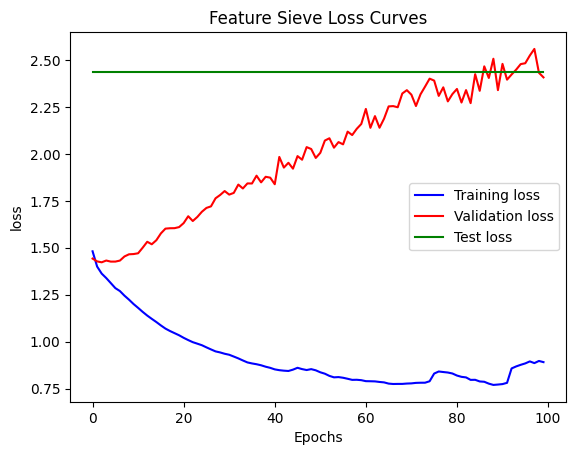

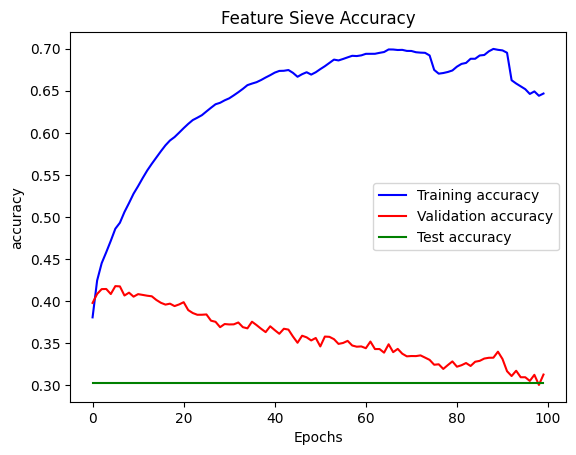

In [16]:
plot_loss_curves(train_loss, val_loss, test_loss, model_name = "Feature Sieve Loss Curves", metric = "loss")
plot_loss_curves(train_accs, val_accs, test_accs, model_name = "Feature Sieve Accuracy", metric = "accuracy")

## Architecture 2:
Auxilary network connected to the 2nd convolutional layer

In [14]:
class Feature_Sieve2(nn.Module):
    def __init__(self, num_channels, num_actions):
        super(Feature_Sieve2, self).__init__()
        self.num_actions = num_actions

        #Main Network
        self.conv1 = nn.Conv2d(num_channels, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

        #Aux network
        self.aux_fc1 = nn.Linear(5184, 512)
        self.aux_fc2 = nn.Linear(512, num_actions)

        self.params = nn.ModuleDict(
            {
                "main" : nn.ModuleList([self.conv1, self.conv2, self.conv3, self.fc1, self.fc2]),
                "aux" : nn.ModuleList([self.aux_fc1, self.aux_fc2]),
                "forget" : nn.ModuleList([self.conv1])
            }
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        sh = F.relu(self.conv2(x))
        x = F.relu(self.conv3(sh))
        
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        aux = sh.reshape(sh.shape[0], -1)
        aux = F.relu(self.aux_fc1(aux))
        aux = self.aux_fc2(aux)

        return x, aux

In [21]:
# training Feature Sieve architecture 2
model = Feature_Sieve2(4, 6).to(device)
model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose=False, epochs =100)
test_loss, test_acc = eval_fsmodel(model, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:36:22<00:00, 93.82s/it]


Test Loss: 7.041356086730957 Test Accuracy :0.32012


In [22]:
plot_losss_curves(train_loss, val_loss, test_loss, model_name = "Feature Sieve 2 Loss", metric = "Loss")
plot_loss_curves(train_accs, val_accs, test_acc, model_name = "Feature Sieve 2 Accuracy", metric = "Accuracy")

NameError: name 'plot_losss_curves' is not defined

In [16]:
#Hyper parameter tuning of the feature Sieve model
forget_lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
forget_iters = [2, 5, 10, 20, 30, 50, 60, 70, 80, 90, 100]
lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]

# test_accs = []
# for forget_lr in forget_lrs:
#     print(f"Forget Lr: {forget_lr}")
#     model = Feature_Sieve(4, 6).to(device)
#     model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose=False, epochs=5, lrs = [1e-3, 1e-3, forget_lr])
#     test_loss, test_acc = eval_fsmodel(model, test_dataloader)
#     test_accs.append(test_acc)

# best_forget_lr = forget_lrs[test_accs.index(max(test_accs))]
# print(f"Best Forget LR: {best_forget_lr}")

# test_accs = []
# for forget_iter in forget_iters:
#     print(f"Forget iter: {forget_iter}")
#     model = Feature_Sieve(4, 6).to(device)
#     model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose=False, epochs=5, forget_iters=forget_iter, lrs=[1e-3,1e-3,best_forget_lr])
#     test_loss, test_acc = eval_fsmodel(model, test_dataloader)
#     test_accs.append(test_acc)

# best_forget_iter = forget_iters[test_accs.index(max(test_accs))]
# print(f"Best forget iter: {best_forget_iter}")

best_forget_lr = 0.0001
best_forget_iter = 10

test_accs = []
for lr in lrs:
    print(f"LR: {lr}")
    model = Feature_Sieve(4,6).to(device)
    model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose = False, epochs=5, forget_iters=best_forget_iter, lrs=[lr, lr, best_forget_lr])
    test_loss, test_acc = eval_fsmodel(model, test_dataloader)
    test_accs.append(test_acc)

best_lr = lrs[test_accs.index(max(test_accs))]
print(f"Best Lr: {best_lr}")

LR: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:18<00:00, 99.73s/it]


Test Loss: 1.7731949090957642 Test Accuracy :0.22512
LR: 5e-05


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:23<00:00, 100.60s/it]


Test Loss: 1.437415599822998 Test Accuracy :0.40728
LR: 0.0001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:22<00:00, 100.55s/it]


Test Loss: 1.4795513153076172 Test Accuracy :0.40472
LR: 0.0005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:21<00:00, 100.40s/it]


Test Loss: 1.5752860307693481 Test Accuracy :0.40528
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:23<00:00, 100.78s/it]


Test Loss: 1.4900609254837036 Test Accuracy :0.40232
LR: 0.005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:23<00:00, 100.63s/it]


Test Loss: 1.7889174222946167 Test Accuracy :0.18224
LR: 0.01


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:23<00:00, 100.68s/it]


Test Loss: 1.6700743436813354 Test Accuracy :0.27608
LR: 0.05


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:20<00:00, 100.00s/it]


Test Loss: 1.790500283241272 Test Accuracy :0.18224
Best Lr: 5e-05


In [15]:
#Training a CNN model with the Early stopper
best_lr_cnn = 3e-5

model = CNN(4, 6).to(device)
model, train_loss, train_acc, val_loss, val_acc = train_cnn(model, train_dataloader, val_dataloader, epochs = 20, verbose=False, early_stop = True, lr=best_lr_cnn, min_delta = 0.1)
test_loss, test_acc = eval_cnn(model, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:53<00:00, 59.67s/it]


Test Loss: 1.9342814683914185 Accuracy:0.36892


In [16]:
# Training the Feature Sieve model with an Early Stopper
best_forget_lr = 0.0001
best_forget_iter = 10
best_lr = 5e-5

model = Feature_Sieve(4, 6).to(device)
model, train_loss_fs, train_acc_fs, val_loss_fs, val_acc_fs = train_fs(model, train_dataloader, val_dataloader, epochs = 20, verbose = False, early_stop = True, lrs = [best_lr, best_lr, best_forget_lr], forget_iters= best_forget_iter, min_delta = 0.1)
test_loss_fs, test_acc_fs = eval_fsmodel(model, test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [33:55<00:00, 101.80s/it]


Test Loss: 1.7054579257965088 Test Accuracy :0.3708


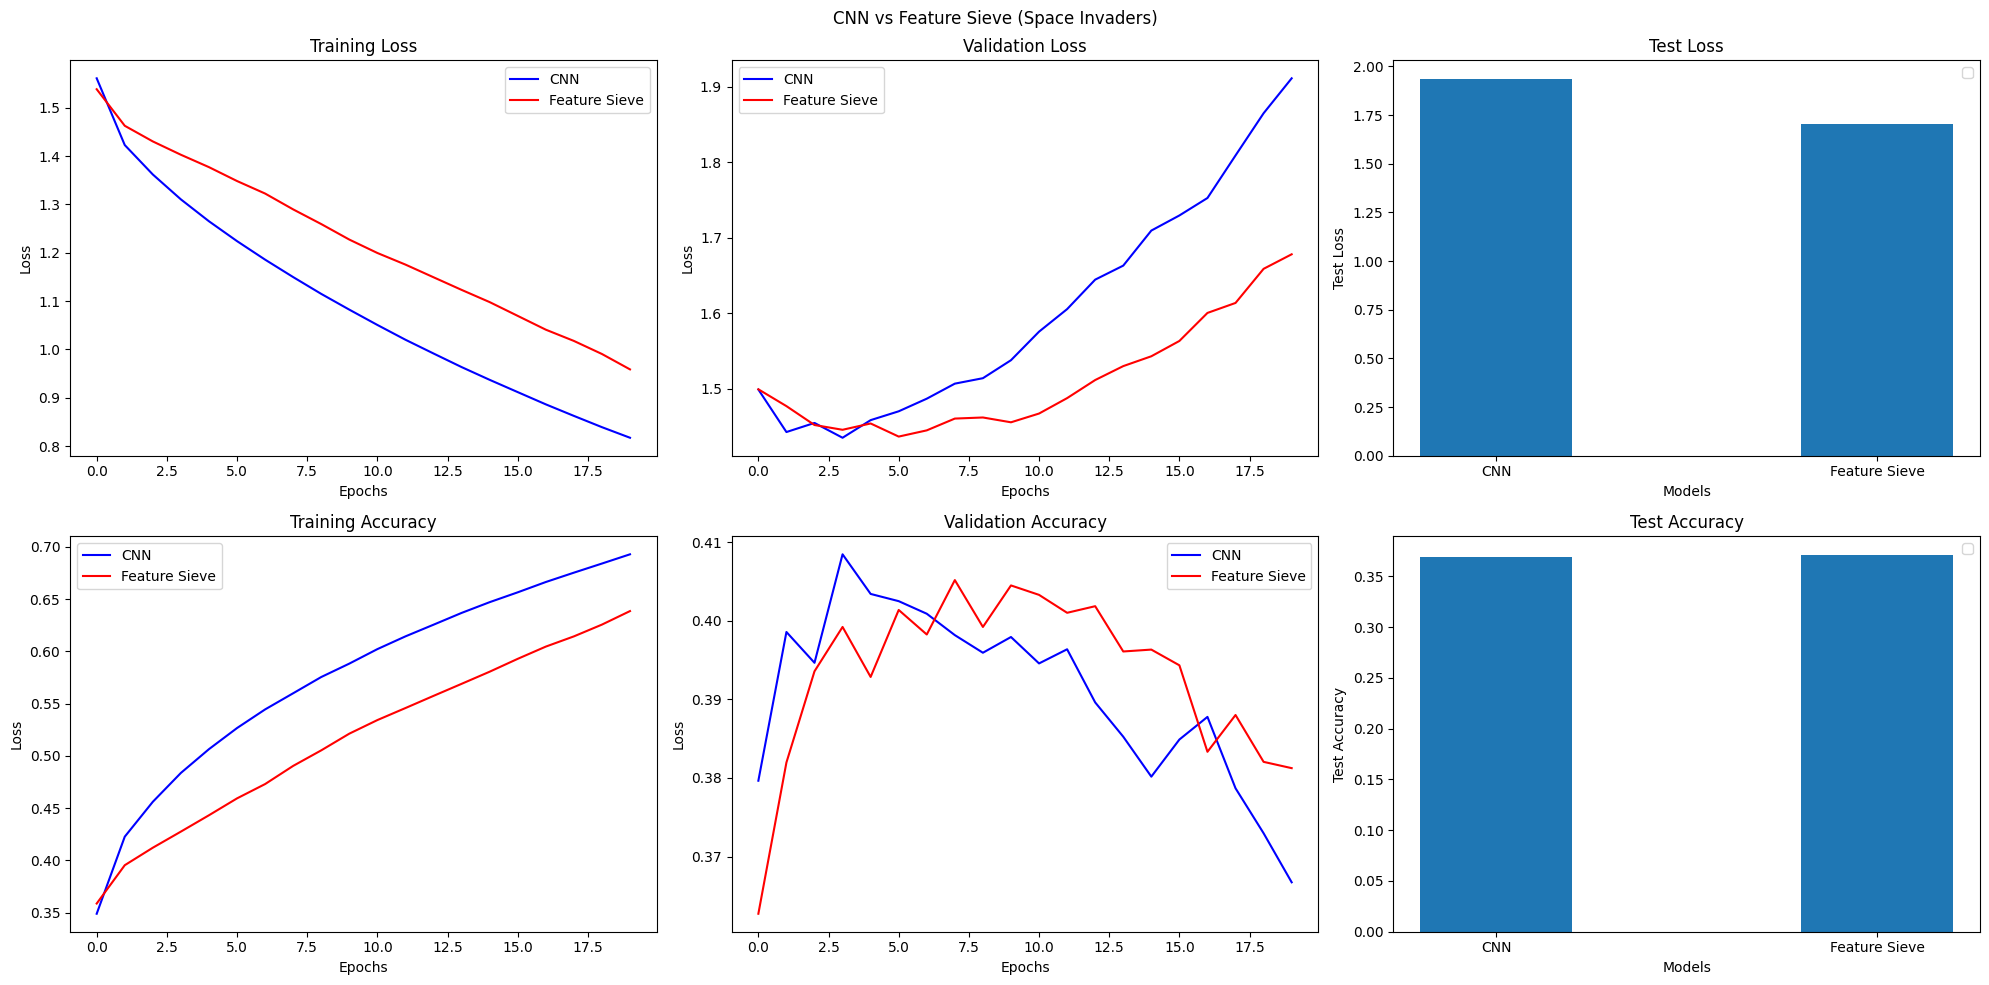

In [23]:
# Plotting the Comparisons
plt.rcParams["figure.figsize"] = (20, 10)
fig, ax = plt.subplots(2, 3)
fig.suptitle("CNN vs Feature Sieve (Space Invaders)")

# Training Loss
ax[0,0].plot(range(len(train_loss)), train_loss, color = "blue", label = "CNN")
ax[0,0].plot(range(len(train_loss_fs)), train_loss_fs,color = "red", label= "Feature Sieve")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Loss")
ax[0,0].set_title("Training Loss")
ax[0,0].legend()

#Validation Loss
ax[0,1].plot(range(len(val_loss)), val_loss, color = "blue", label = "CNN")
ax[0,1].plot(range(len(val_loss_fs)), val_loss_fs, color = "red", label= "Feature Sieve")
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Loss")
ax[0,1].set_title("Validation Loss")
ax[0,1].legend()

#Training  Accuracy
ax[1,0].plot(range(len(train_acc)), train_acc, color = "blue", label = "CNN")
ax[1,0].plot(range(len(train_acc_fs)), train_acc_fs,color = "red", label= "Feature Sieve")
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Loss")
ax[1,0].set_title("Training Accuracy")
ax[1,0].legend()

#Validation Accuracy
ax[1,1].plot(range(len(val_loss)), val_acc, color = "blue", label = "CNN")
ax[1,1].plot(range(len(val_loss_fs)), val_acc_fs, color = "red", label= "Feature Sieve")
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Loss")
ax[1,1].set_title("Validation Accuracy")
ax[1,1].legend()

#Test Loss:
models = ["CNN", "Feature Sieve"]
test_losses = [test_loss, test_loss_fs]
ax[0,2].bar(models, test_losses, width = 0.4)
ax[0,2].set_xlabel("Models")
ax[0,2].set_ylabel("Test Loss")
ax[0,2].set_title("Test Loss")
ax[0,2].legend()

# Test accuracy
test_accs = [test_acc, test_acc_fs]
ax[1,2].bar(models, test_accs, width = 0.4)
ax[1,2].set_xlabel("Models")
ax[1,2].set_ylabel("Test Accuracy")
ax[1,2].set_title("Test Accuracy")
ax[1,2].legend()

plt.tight_layout()
plt.savefig("./Outputs/cnn_vs_fs.png")
plt.show()

In [24]:
# saving all the observations
np.save("./Datasets/space_invaders_obs.npy", observations)
np.save("./Datasets/space_invaders_actions.npy", actions)